In [7]:
import pandas as pd 

# Load 2016 ridership data
df_2016 = pd.read_csv('2016data.csv')  # Adjust filename if needed

# Load 2024 ridership data
df_2024 = pd.read_csv('2024Ridershipdata.csv')  # Adjust filename if needed

# Define month mapping for consistency
month_mapping = {'March': 3, 'June': 6, 'September': 9, 'December': 12}

# Fix for 2016 data: Extract month name and map to numeric
df_2016['month'] = df_2016['Month'].str.strip().map(month_mapping)

# Fix for 2024 data: Extract month name from "December 04" and map to numeric
df_2024['month'] = df_2024['Date'].str.split().str[0].str.strip().map(month_mapping)

# Strip any leading/trailing spaces from column names
df_2016.columns = df_2016.columns.str.strip()
df_2024.columns = df_2024.columns.str.strip()

# Select required columns
df_2016 = df_2016[['month', 'Station Name', 'Avg Daily Entries']]
df_2024 = df_2024[['month', 'Station Name', 'Avg Daily Entries']]

# Keep only the same Purple Line stations
purple_line_stations = ['Bethesda', 'Silver Spring', 'College Park-U of Md', 'New Carrollton']
df_2016 = df_2016[df_2016['Station Name'].isin(purple_line_stations)]
df_2024 = df_2024[df_2024['Station Name'].isin(purple_line_stations)]

# Convert 'Avg Daily Entries' to numeric, handling 'K' suffix
df_2016['Avg Daily Entries'] = df_2016['Avg Daily Entries'].replace({'K': '*1e3'}, regex=True).map(pd.eval).astype(float)
df_2024['Avg Daily Entries'] = df_2024['Avg Daily Entries'].replace({'K': '*1e3'}, regex=True).map(pd.eval).astype(float)

# Fix the inplace FutureWarning issue by assigning the result back to the DataFrame
df_2016 = df_2016.assign(Avg_Daily_Entries=df_2016['Avg Daily Entries'].fillna(0))
df_2024 = df_2024.assign(Avg_Daily_Entries=df_2024['Avg Daily Entries'].fillna(0))

# Ensure only the expected months exist in both datasets
all_months = [3, 6, 9, 12]
df_2016 = df_2016[df_2016['month'].isin(all_months)]
df_2024 = df_2024[df_2024['month'].isin(all_months)]

# Print the DataFrames to verify
print(df_2016)
print(df_2024)

# Aggregate ridership: Average daily ridership per station and month
df_2016_avg = df_2016.groupby(['Station Name', 'month'])['Avg Daily Entries'].mean().reset_index()
df_2024_avg = df_2024.groupby(['Station Name', 'month'])['Avg Daily Entries'].mean().reset_index()

# Print the aggregated DataFrames to verify
print(df_2016_avg)
print(df_2024_avg)


      month          Station Name  Avg Daily Entries  Avg_Daily_Entries
21       12         Silver Spring             2500.0             2500.0
33       12        New Carrollton              700.0              700.0
76       12  College Park-U of Md              900.0              900.0
85       12              Bethesda             3100.0             3100.0
113      12         Silver Spring             2200.0             2200.0
...     ...                   ...                ...                ...
1730      3              Bethesda             1200.0             1200.0
1758      3         Silver Spring             5800.0             5800.0
1770      3        New Carrollton             4800.0             4800.0
1813      3  College Park-U of Md             1700.0             1700.0
1822      3              Bethesda             2900.0             2900.0

[80 rows x 4 columns]
      month          Station Name  Avg Daily Entries  Avg_Daily_Entries
98     12.0         Silver Spring        

In [8]:
stations = ['Bethesda', 'Silver Spring', 'College Park-U of Md', 'New Carrollton']
months = [3, 6, 9, 12]

# Create a DataFrame with all possible station-month combinations
full_index = pd.MultiIndex.from_product([stations, months], names=['Station Name', 'month'])
df_2016_avg = df_2016_avg.set_index(['Station Name', 'month']).reindex(full_index, fill_value=0).reset_index()
df_2024_avg = df_2024_avg.set_index(['Station Name', 'month']).reindex(full_index, fill_value=0).reset_index()

In [9]:
# Merge 2016 and 2024 data on station and month
df_comparison = pd.merge(df_2016_avg, df_2024_avg, on=['Station Name', 'month'], suffixes=('_2016', '_2024'))

# Calculate ridership change
df_comparison['Change'] = df_comparison['Avg Daily Entries_2024'] - df_comparison['Avg Daily Entries_2016']
df_comparison['Percent Change'] = (df_comparison['Change'] / df_comparison['Avg Daily Entries_2016']) * 100

# Print final comparison table
print(df_comparison)



            Station Name  month  Avg Daily Entries_2016  \
0               Bethesda      3                  1900.0   
1               Bethesda      6                  1960.0   
2               Bethesda      9                  1780.0   
3               Bethesda     12                  1660.0   
4          Silver Spring      3                  2440.0   
5          Silver Spring      6                  2520.0   
6          Silver Spring      9                  2340.0   
7          Silver Spring     12                  2080.0   
8   College Park-U of Md      3                   800.0   
9   College Park-U of Md      6                  1040.0   
10  College Park-U of Md      9                   840.0   
11  College Park-U of Md     12                   660.0   
12        New Carrollton      3                  1500.0   
13        New Carrollton      6                   920.0   
14        New Carrollton      9                  1280.0   
15        New Carrollton     12                  1140.0 

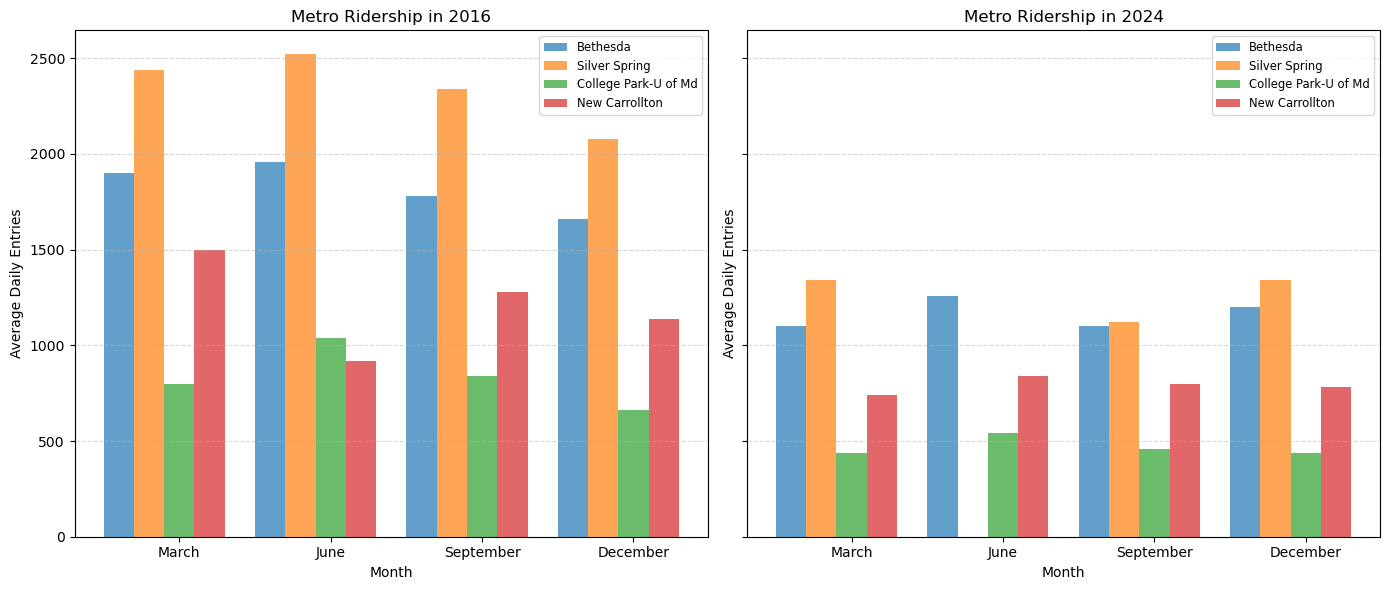

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure 'stations' and 'months' are defined
stations = ['Bethesda', 'Silver Spring', 'College Park-U of Md', 'New Carrollton']
months = [3, 6, 9, 12]
month_labels = ['March', 'June', 'September', 'December']

# Set up two subplots for separate graphs (one for 2016, one for 2024)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Define bar width and positions
bar_width = 0.2
x = np.arange(len(months))  # X-axis positions

# Plot for 2016 ridership
axes[0].set_title('Metro Ridership in 2016')
for i, station in enumerate(stations):
    subset = df_comparison[df_comparison['Station Name'] == station]
    axes[0].bar(x + (i - len(stations)/2) * bar_width, 
                subset['Avg Daily Entries_2016'], width=bar_width, label=f'{station}', alpha=0.7)

# Plot for 2024 ridership
axes[1].set_title('Metro Ridership in 2024')
for i, station in enumerate(stations):
    subset = df_comparison[df_comparison['Station Name'] == station]
    axes[1].bar(x + (i - len(stations)/2) * bar_width, 
                subset['Avg Daily Entries_2024'], width=bar_width, label=f'{station}', alpha=0.7)

# Formatting both plots
for ax in axes:
    ax.set_xticks(x)
    ax.set_xticklabels(month_labels)
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Daily Entries')
    ax.legend(loc='upper right', fontsize='small', ncol=1)  # Adjust legend for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Show the visualization
plt.tight_layout()
plt.show()



In [35]:
import pandas as pd 

# Load 2016 ridership data
df_2016 = pd.read_csv('2016data.csv')  # Adjust filename if needed

# Load 2024 ridership data
df_2024 = pd.read_csv('2024Ridershipdata.csv')  # Adjust filename if needed

# Define month mapping for consistency
month_mapping = {'March': 3, 'June': 6, 'September': 9, 'December': 12}

# Fix for 2016 data: Extract month name and map to numeric
df_2016['month'] = df_2016['Month'].str.strip().map(month_mapping)

# Fix for 2024 data: Extract month name from "December 04" and map to numeric
df_2024['month'] = df_2024['Date'].str.split().str[0].str.strip().map(month_mapping)

# Strip any leading/trailing spaces from column names
df_2016.columns = df_2016.columns.str.strip()
df_2024.columns = df_2024.columns.str.strip()

# Select required columns
df_2016 = df_2016[['month', 'Station Name', 'Avg Daily Entries']]
df_2024 = df_2024[['month', 'Station Name', 'Avg Daily Entries']]

# List of unaffected stations
unaffected_stations = ['Dupont Circle', 'Gallery Place', 'Union Station', 'Metro Center']

# Filter to keep only the unaffected stations
df_2016 = df_2016[df_2016['Station Name'].isin(unaffected_stations)]
df_2024 = df_2024[df_2024['Station Name'].isin(unaffected_stations)]

# Convert 'Avg Daily Entries' to numeric, handling 'K' suffix
def convert_entries(value):
    if pd.isna(value) or value == 'nan':  # Handle NaN values
        return 0
    value = str(value).strip()  # Ensure it's a string for replacement
    if 'K' in value:
        return float(value.replace('K', '')) * 1000  # Convert 'K' notation
    return float(value)

df_2016['Avg Daily Entries'] = df_2016['Avg Daily Entries'].apply(convert_entries)
df_2024['Avg Daily Entries'] = df_2024['Avg Daily Entries'].apply(convert_entries)

# Ensure only the expected months exist in both datasets
all_months = [3, 6, 9, 12]
df_2016 = df_2016[df_2016['month'].isin(all_months)]
df_2024 = df_2024[df_2024['month'].isin(all_months)]

# Print the DataFrames to verify
print(df_2016)
print(df_2024)

# Aggregate ridership: Average daily ridership per station and month
df_2016_avg = df_2016.groupby(['Station Name', 'month'])['Avg Daily Entries'].mean().reset_index()
df_2024_avg = df_2024.groupby(['Station Name', 'month'])['Avg Daily Entries'].mean().reset_index()

# Print the aggregated DataFrames to verify
print(df_2016_avg)
print(df_2024_avg)



      month   Station Name  Avg Daily Entries
10       12  Union Station             9100.0
39       12   Metro Center            12400.0
55       12  Gallery Place            10500.0
68       12  Dupont Circle             6200.0
102      12  Union Station             4600.0
...     ...            ...                ...
1713      3  Dupont Circle             3700.0
1747      3  Union Station             9100.0
1776      3   Metro Center             1600.0
1792      3  Gallery Place             1600.0
1805      3  Dupont Circle             3500.0

[80 rows x 3 columns]
      month   Station Name  Avg Daily Entries
0      12.0   Metro Center            10100.0
1       6.0   Metro Center             9700.0
2       9.0   Metro Center             9300.0
3       3.0   Metro Center             9200.0
18     12.0  Gallery Place             7100.0
...     ...            ...                ...
1816    6.0  Dupont Circle                0.0
1855    3.0  Union Station                0.0
1886    3.0

     Station Name  month  Avg Daily Entries_2016  Avg Daily Entries_2024  \
0   Dupont Circle      3                  3660.0                  2280.0   
1   Dupont Circle      6                  3680.0                  2400.0   
2   Dupont Circle      9                  3240.0                  2200.0   
3   Dupont Circle     12                  2880.0                  2560.0   
4   Gallery Place      3                  5220.0                  3140.0   
5   Gallery Place      6                  4700.0                  2680.0   
6   Gallery Place      9                  4140.0                  2440.0   
7   Gallery Place     12                  4460.0                  3000.0   
8   Union Station      3                  5820.0                  3320.0   
9   Union Station      6                  6120.0                  3480.0   
10  Union Station      9                  5500.0                  3120.0   
11  Union Station     12                  4880.0                  3680.0   
12   Metro C

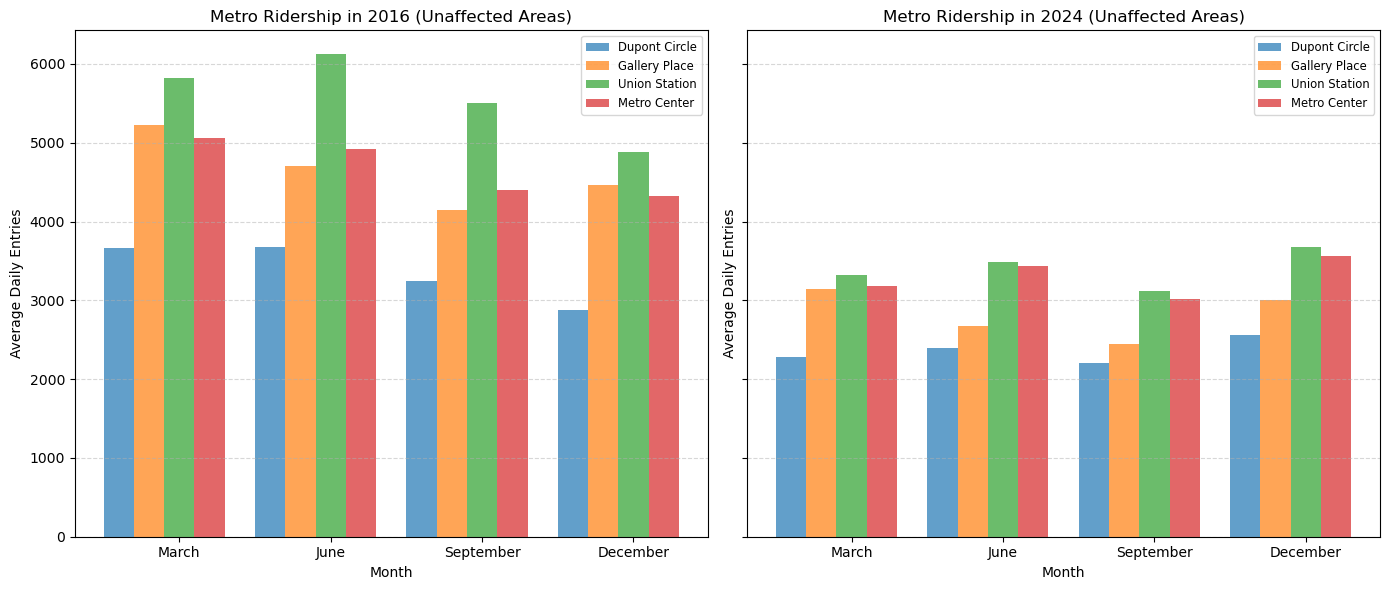

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define months and month labels
months = [3, 6, 9, 12]
month_labels = ['March', 'June', 'September', 'December']

# Define specific unaffected stations
unaffected_stations = ['Dupont Circle', 'Gallery Place', 'Union Station', 'Metro Center']

# Create a DataFrame with all possible station-month combinations
full_index = pd.MultiIndex.from_product([unaffected_stations, months], names=['Station Name', 'month'])
df_2016_avg = df_2016_avg.set_index(['Station Name', 'month']).reindex(full_index, fill_value=0).reset_index()
df_2024_avg = df_2024_avg.set_index(['Station Name', 'month']).reindex(full_index, fill_value=0).reset_index()

# Merge 2016 and 2024 data on station and month
df_comparison = pd.merge(df_2016_avg, df_2024_avg, on=['Station Name', 'month'], suffixes=('_2016', '_2024'))

# Calculate ridership change
df_comparison['Change'] = df_comparison['Avg Daily Entries_2024'] - df_comparison['Avg Daily Entries_2016']
df_comparison['Percent Change'] = (df_comparison['Change'] / df_comparison['Avg Daily Entries_2016']) * 100

# Print final comparison table
print(df_comparison)

# Set up two subplots for separate graphs (one for 2016, one for 2024)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Define bar width and positions
bar_width = 0.2
x = np.arange(len(months))  # X-axis positions

# Plot for 2016 ridership
axes[0].set_title('Metro Ridership in 2016 (Unaffected Areas)')
for i, station in enumerate(unaffected_stations):
    subset = df_comparison[df_comparison['Station Name'] == station]
    axes[0].bar(x + (i - len(unaffected_stations)/2) * bar_width, 
                subset['Avg Daily Entries_2016'], width=bar_width, label=f'{station}', alpha=0.7)

# Plot for 2024 ridership
axes[1].set_title('Metro Ridership in 2024 (Unaffected Areas)')
for i, station in enumerate(unaffected_stations):
    subset = df_comparison[df_comparison['Station Name'] == station]
    axes[1].bar(x + (i - len(unaffected_stations)/2) * bar_width, 
                subset['Avg Daily Entries_2024'], width=bar_width, label=f'{station}', alpha=0.7)

# Formatting both plots
for ax in axes:
    ax.set_xticks(x)
    ax.set_xticklabels(month_labels)
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Daily Entries')
    ax.legend(loc='upper right', fontsize='small', ncol=1)  # Adjust legend for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Show the visualization
plt.tight_layout()
plt.show()
